# Masked sifting
Here i was was introduced to issues that standard EMD algorithms can
have with intermitent signals and shows how the Masked sift can resolve them.


Text(0.5, 0, 'Samples')

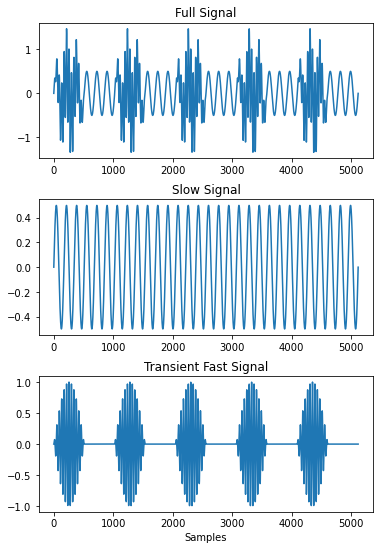

In [1]:
import emd
import numpy as np
import matplotlib.pyplot as plt

seconds = 5
sample_rate = 1024
time_vect = np.linspace(0, seconds, seconds*sample_rate)

# Create an amplitude modulation
am = np.sin(2*np.pi*time_vect)
am[am < 0] = 0

# Create a 25Hz signal and introduce the amplitude modulation
xx = am*np.sin(2*np.pi*25*time_vect)

# Create a non-modulated 6Hz signal
yy = .5*np.sin(2*np.pi*6*time_vect)

# Sum the 25Hz and 6Hz components together
xy = xx+yy

# Make a quick summary plot
plt.figure(figsize=(6,9))
plt.subplots_adjust(hspace=0.3)
plt.subplot(311)
plt.plot(xy)
plt.title('Full Signal')
plt.subplot(312)
plt.plot(yy)
plt.title('Slow Signal')
plt.subplot(313)
plt.plot(xx)
plt.title('Transient Fast Signal')
plt.xlabel('Samples')


The above simulated signal doesnt contain any noise but the 25Hz component doesnt look what it should look like in the EMD plot

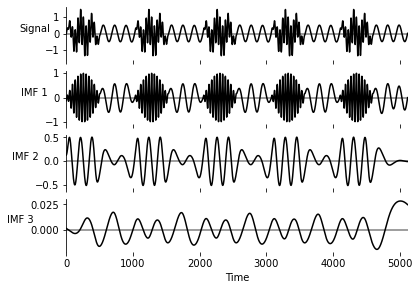

In [3]:
imf = emd.sift.sift(xy, max_imfs=3)
emd.plotting.plot_imfs(imf)

The above problem can be solved by adding a masked signal by running a ``emd.sift.get_next_imf``. Any signals which are lower in
frequency than this mask should then be ignored by the sift in favour of this
known signal. Finally, we can remove the known mask to recover our IMF.

First, lets make a new signal and add it to the previous one

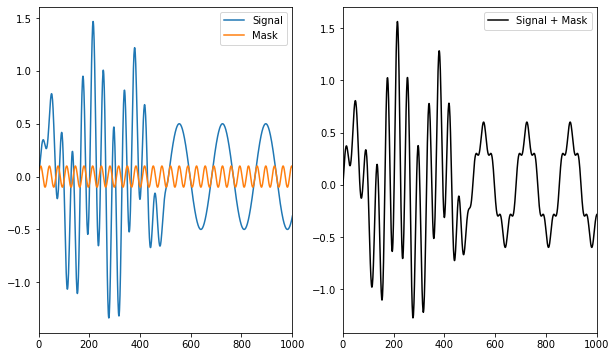

In [5]:
mask = 0.1*np.sin(2*np.pi*30*time_vect)
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(xy)
plt.plot(mask)
plt.legend(['Signal', 'Mask'])
plt.xlim(0, 1000)
plt.subplot(122)
plt.plot(xy + mask, color='k')
plt.xlim(0, 1000)
plt.legend(['Signal + Mask'])


As we previously observed, the normal IMF in the top panel exhibits a leak of the slow signal into the fast IMF. However, the masked IMF effectively eliminates this slow signal and replaces it with the mask frequency. By subtracting the mask, we are left with only the 25Hz oscillation, which is accurately absent during bursts.

In [8]:
imf_raw, _ = emd.sift.get_next_imf(xy)
imf_mask, _ = emd.sift.get_next_imf(xy+mask)

Text(0.5, 1.0, 'Masked IMF with Mask removed')

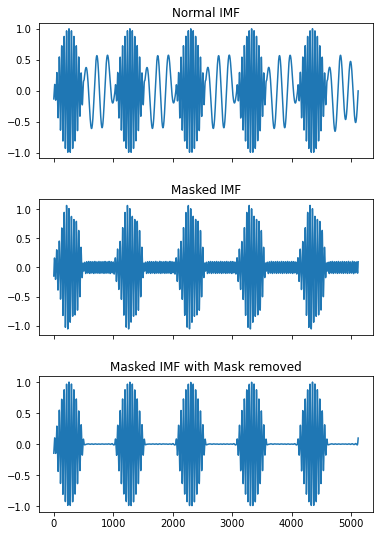

In [7]:
plt.figure(figsize=(6, 9))
plt.subplots_adjust(hspace=0.3)
plt.subplot(311)
plt.plot(imf_raw)
plt.title('Normal IMF')
plt.gca().set_xticklabels([])
plt.subplot(312)
plt.plot(imf_mask)
plt.title('Masked IMF')
plt.gca().set_xticklabels([])
plt.subplot(313)
plt.plot(imf_mask - mask[:, np.newaxis])
plt.title('Masked IMF with Mask removed')

The masking procedure is carried out in the function emd.sift.get_next_imf_mask, which operates similarly to emd.sift.get_next_imf with additional options for applying masks. With this function, we can specify the frequency and strength of the mask to be used when isolating the IMF.

The next step is to choose an ideal mask frequency 

Text(0.5, 1.0, '2Hz mask - too low')

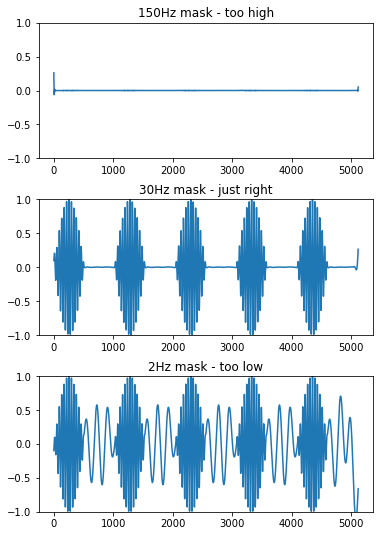

In [10]:
# Masks should be specified in normalised frequencies between 0 and .5 where 0.5 is half the sampling rate
high_mask_freq = 150/sample_rate
imf_high_mask, _ = emd.sift.get_next_imf_mask(xy, high_mask_freq, 2)

med_mask_freq = 30/sample_rate
imf_med_mask, _ = emd.sift.get_next_imf_mask(xy, med_mask_freq, 2)

low_mask_freq = 2/sample_rate
imf_low_mask, _ = emd.sift.get_next_imf_mask(xy, low_mask_freq, 2)

plt.figure(figsize=(6, 9))
plt.subplots_adjust(hspace=0.3)
plt.subplot(311)
plt.plot(imf_high_mask)
plt.title('150Hz mask - too high')
plt.ylim(-1, 1)
plt.subplot(312)
plt.plot(imf_med_mask)
plt.ylim(-1, 1)
plt.title('30Hz mask - just right')
plt.subplot(313)
plt.plot(imf_low_mask)
plt.ylim(-1, 1)
plt.title('2Hz mask - too low')

There is a function ``emd.sift.mask_sift`` uses ``emd.sift.get_next_imf_mask`` internally to run a whole set of sifts using the masking method. Each IMF is isolated with a separate mask which decreases in frequency for each successive IMF.

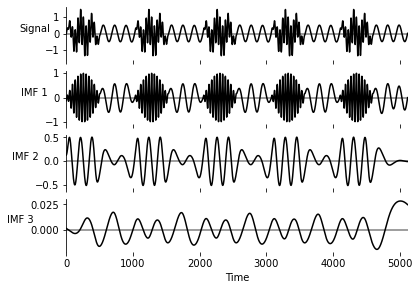

In [11]:
emd.plotting.plot_imfs(imf)